In [38]:
# from hmmlearn import hmm
%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
# import pykovy-master/ 
from pykovy.src.pykovy import chain
import matplotlib.pyplot as plt
from time import time
import networkx as nx
import math

In [3]:

# np.random.seed(42)

# model = hmm.GaussianHMM(n_components=3, covariance_type="full")
# model.startprob_ = np.array([0.6, 0.3, 0.1])
# model.transmat_ = np.array([[0.7, 0.2, 0.1],
#                             [0.3, 0.5, 0.2],
#                             [0.3, 0.3, 0.4]])
# model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
# model.covars_ = np.tile(np.identity(2), (3, 1, 1))
# X, Z = model.sample(100)

In [4]:
# df = pd.read_csv('../all_data.csv')
# df = df[['Client Username', 'Association Time', 'Map Location', 'Session Duration']]


In [5]:
# re-code userid
# df['Client Username'] = pd.Categorical(df['Client Username'])
# df['Client Username'] = df['Client Username'].cat.codes


In [6]:
df = pd.read_csv('../all_data.csv')
df = df[['Client Username', 'Association Time', 'Map Location', 'Session Duration', 'Client MAC Address']]
df = df.assign(id=(df['Client Username'] + '_' + df['Client MAC Address']).astype('category').cat.codes)


In [7]:
df = df.drop(['Client Username', 'Client MAC Address'], axis=1)
df.rename(columns={'id':'Client Username'}, inplace=True)
df = df[['Client Username', 'Association Time', 'Map Location', 'Session Duration']]


In [8]:
# recode map location
map_dict = {}
count = 0
for i in df['Map Location'].unique():
    map_dict[i] = count
    count += 1
df['Map Location'] = df['Map Location'].map(map_dict)

In [9]:
# df[df['Map Location']==64]

In [10]:
def timer(func):
    # this part is for timer ignore
    def wrapper(*arg):
        before = time()
        rv = func(*arg)
        after = time()
        print('Elapsed: ', after-before)
        return rv
    return wrapper

def convertMonth(month):
    if month == 'Jan': return 1
    elif month == 'Feb': return 2
    elif month == 'Mar': return 3
    elif month == 'Apr': return 4
    elif month == 'May': return 5
    elif month == 'Jun': return 6
    elif month == 'Jul': return 7
    elif month == 'Aug': return 8
    elif month == 'Sep': return 9
    elif month == 'Oct': return 10
    elif month == 'Nov': return 11
    elif month == 'Dec': return 12
    else: print('error input is not correct')
        
def convert_to_timeslot(duration):
    temp = duration.split()
    if len(temp) == 2: sess_duration = int(temp[0])
    elif len(temp) == 4: sess_duration = int(temp[0]) * 60 + int(temp[2])
    elif len(temp) == 6: sess_duration = (int(temp[0]) * 60 + int(temp[2])) * 60 + int(temp[4])
    else: print('error')
    return datetime.timedelta(seconds=sess_duration)

def convert_to_datetime(time):
    temp = time.split()
    d_time = datetime.datetime(year=int(temp[5]), month=convertMonth(temp[1]), day=int(temp[2]), hour=int(temp[3].split(':')[0]), minute=int(temp[3].split(':')[1]), second=int(temp[3].split(':')[2]))
    return d_time

# data_list has same number of row as df.
# Each row [userid, map_loc, associate_time, associate_time+sess_dur, sess_dur].
def create_data_list(df):
    data_list = []
    c=0
    for i in range(df.shape[0]):
        if c%500000 == 0:
            print(c)
        sess = convert_to_timeslot(df.iloc[i,3])
        s_time = convert_to_datetime(df.iloc[i,1])
        e_time = s_time + sess
        data_list.append([df.iloc[i,0], df.iloc[i,2], s_time, e_time, sess])
        c+=1
        
    data_list = sorted(data_list, key=lambda element: (element[0], element[2]))
    data_list1 = sorted(data_list, key=lambda element: (element[2]))
    first = data_list1[0][2]
    last = data_list1[-1][2]
    return data_list, first, last

# add up the session duration when the previous row has the same userid and location. 
# (this happen when you disconnect from the ap and reconnect again or your wifi session expire, etc.)
def preprocess_data_list(df, data_list):
    for i in reversed(range(1, df.shape[0])):
        if data_list[i][0] == data_list[i-1][0] and data_list[i][1] == data_list[i-1][1]:
#             if data_list[i][2] - data_list[i-1][3] <= datetime.timedelta(hours=2):
            data_list[i-1][4] += data_list[i][4]
#             else: print(i)
    # loop each row, remove the next concecutive rows has the same userid and map_loc with the current row.
    # Because they are useless now
    final_data_list = []
    i = 0
    while i < df.shape[0]-1:
        if data_list[i][0] == data_list[i+1][0] and data_list[i][1] == data_list[i+1][1]:
            final_data_list.append(data_list[i])
            c = 2
            while i+c <= df.shape[0]-1 and data_list[i][0] == data_list[i+c][0] and data_list[i][1] == data_list[i+c][1]:
                c += 1
            i += c

        else:
            final_data_list.append(data_list[i])
            i += 1

    if not (final_data_list[-1][0] == data_list[-1][0] and final_data_list[-1][1] == data_list[-1][1]):
        final_data_list.append(data_list[-1])

    return final_data_list


# user_dict's key are each userid and value is a list of all rows of each user in final_data_list
def create_user_dict(final_data_list):
    user_dict = defaultdict(list)
    for row in final_data_list:
        user_dict[row[0]].append([row[2], row[1], row[4]])
        
#     for usr in user_dict:
#         user_dict[usr].sort()

    return user_dict

# 
def remove_jitter(final_data_list):
    res = [final_data_list[0]]
    i = 1
    mem = 0
    while i < len(final_data_list):
        cur_usrid = final_data_list[i][0]
        cur_loc = final_data_list[i][1]
        cur_sess = final_data_list[i][4]
        cur_end_time = final_data_list[i][2] + final_data_list[i][4]
        cont_time = final_data_list[i][2] - (res[-1][2] + res[-1][4]) <= datetime.timedelta(minutes=1)
        if cur_usrid == res[-1][0] and cur_sess <= datetime.timedelta(minutes=1) and cont_time:


            if cur_loc != res[-1][1] and mem == 0:
                mem = i

            elif cur_loc == res[-1][1]:
                
#                 print(i, cur_loc, cur_end_time, res[-1][1], res[-1][2])

#                 print(cur_end_time - res[-1][2])
                res[-1][4] = cur_end_time - res[-1][2]
#                 print(res[-1][4])
                mem=0
                
            else: pass
        elif cur_usrid == res[-1][0] and cur_sess <= datetime.timedelta(minutes=1) and not cont_time:
            if cur_loc != res[-1][1] and mem == 0:
                res.append(final_data_list[i])

            elif cur_loc == res[-1][1]:
                res[-1][4] = cur_end_time - res[-1][2]
                mem=0
                
            else:                 
                for j in range(mem, i):
                    res.append(final_data_list[j])
                res.append(final_data_list[i])
                mem=0
        else:
            if mem != 0:
                for j in range(mem, i):
                    res.append(final_data_list[j])
                res.append(final_data_list[i])
                mem=0
            else: res.append(final_data_list[i])
        
        i+=1

    return res

@timer
def preprocess_and_create_user_dict(df):
    data_list, start_ts, end_ts= create_data_list(df)
    final_data_list = preprocess_data_list(df, data_list)
    print(len(final_data_list), len(data_list))
    final_data_list = remove_jitter(final_data_list)
    print(len(final_data_list), len(data_list))
    user_dict = create_user_dict(final_data_list)
    return user_dict, start_ts, end_ts


In [11]:
user_dict, start_ts, end_ts = preprocess_and_create_user_dict(df)

0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
2350637 6114987
2350635 6114987
Elapsed:  356.18208384513855


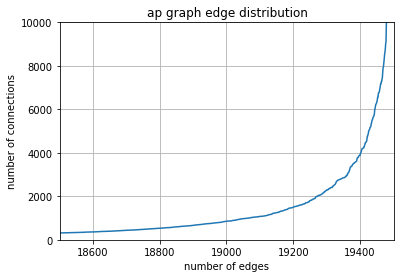

In [12]:
# make an 198x198 graph (198 is the number of aps) this is the graph of the school, 
# the edges are how many connections in total that all students have traveled.
def create_198_198_map(df, user_dict, draw=True):
    num_aps = len(df["Map Location"].unique())
    undir_map = np.zeros(39204, dtype=np.int32).reshape(198, 198)
    for usr in user_dict:
        for i in range(len(user_dict[usr])-1):
            if user_dict[usr][i][1] != user_dict[usr][i+1][1]:
                undir_map[user_dict[usr][i][1]][user_dict[usr][i+1][1]] += 1
                undir_map[user_dict[usr][i+1][1]][user_dict[usr][i][1]] += 1

    
    # draw the number of connections each edge is used. Change ax.set_ylim([0, 75]) to scale the graph
    # try to find the edges that are bad (low connections, too high connections) and prune them
    if draw:
        draw_list = []
        c = 0
        for i in range(len(undir_map)):
            c+=1
            for j in range(len(undir_map[i])-c):
                draw_list.append(undir_map[i][j+c])
        draw_list.sort()
        # Data for plotting
        x = np.arange(0,len(draw_list))

        _, ax = plt.subplots()
        ax.set_xlim([18500, len(draw_list)])
        ax.set_ylim([0, 9999])
        ax.plot(x, draw_list)
        ax.set(xlabel='number of edges', ylabel='number of connections',
               title='ap graph edge distribution')
        ax.grid()
        # fig.savefig("test.png")
        plt.show()
    
    return undir_map

undir_map = create_198_198_map(df, user_dict)

In [42]:
def map_pruning(undir_map, low=50, high=5000):
    size = len(undir_map)
    undir_map1 = np.zeros(size**2, dtype=np.int32).reshape(size, size)

    for i in range(size):
        for j in range(size):
            if undir_map[i][j] >=low and undir_map[i][j] <=high:
                undir_map1[i][j] = 1
            else: undir_map1[i][j] = 0

    return undir_map1

undir_map_prune = map_pruning(undir_map, low=50, high=5000)


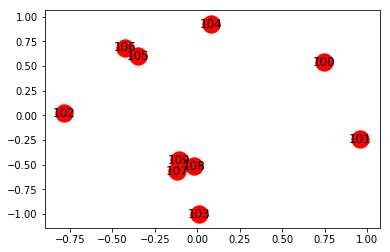

In [43]:
def create_nx_graph(undir_map_prune):
    nx_graph = nx.to_networkx_graph(undir_map_prune)
    res = np.arange(100, 110)
    # nx.draw_networkx(nx_graph, nodelist=res, node_size=[6])
    # pos = nx.spring_layout(nx_graph)  #setting the positions with respect to G, not k.
    k = nx_graph.subgraph(res)

    nx.draw_networkx(k)
    return nx_graph

nx_graph = create_nx_graph(undir_map_prune)

# find all the paths from 2 nodes with length of 3 or less
def find_all_paths(graph, src, dest, cutoff=3):
    paths = nx.algorithms.simple_paths.all_simple_paths(graph, src, dest, cutoff= cutoff)
    return paths

In [44]:
paths = find_all_paths(nx_graph, 3,5)
t = 0
for path in paths:
    t+=1
print(t)

3071


In [45]:
def create_freq_dict(user_dict):
    # time spend on each ap during the entire dataset for each user
    ap_freq_dict = defaultdict(dict)
    total_time_each_usr = {}
    for usr in user_dict:
        for i in range(len(user_dict[usr])): 
            ap_freq_dict[usr][user_dict[usr][i][1]] = datetime.timedelta(0)
            total_time_each_usr[usr] = datetime.timedelta(0)

    for usr in user_dict:
        for i in range(len(user_dict[usr])):
            ap_freq_dict[usr][user_dict[usr][i][1]] += user_dict[usr][i][2]
            total_time_each_usr[usr] += user_dict[usr][i][2]
    
    return ap_freq_dict, total_time_each_usr

ap_freq_dict, _ = create_freq_dict(user_dict)

In [46]:
ap_freq_dict[4900]

{4: datetime.timedelta(seconds=2163),
 19: datetime.timedelta(seconds=13187),
 3: datetime.timedelta(days=1, seconds=27439),
 79: datetime.timedelta(seconds=617),
 11: datetime.timedelta(seconds=1564),
 34: datetime.timedelta(seconds=29582),
 20: datetime.timedelta(seconds=7138),
 44: datetime.timedelta(seconds=305),
 5: datetime.timedelta(seconds=2491),
 35: datetime.timedelta(seconds=9203),
 25: datetime.timedelta(seconds=311),
 9: datetime.timedelta(seconds=1224),
 110: datetime.timedelta(seconds=305)}

In [47]:
# c=0
# for usr in user_dict:
#     for it in user_dict[usr]:
#         if it[2] <= datetime.timedelta(minutes=1):
#             c+=1
#             print(it)
            
# print(c)

In [48]:
# ss = 1114922
# final_data_list[ss-10:ss+10]

In [49]:
# small = datetime.timedelta(seconds = 50)
# test = final_data_list[ss-10:ss+10]
# test1 = []
# for i in range(len(final_data_list[ss-10:ss+10])):
#     if i % 2 == 0:
#         test1.append([test[i][0], test[i][1],test[i][2],test[i][3],test[i][4]])
#     else:
#         test1.append([test1[-1][0], 7,test1[-1][2] + test1[-1][4],test1[-1][3],small])

# for i in range(len(test1)):
#     if i % 2 == 0 and i !=0:
#         test1[i][1] = test1[0][1]

In [51]:
dt = datetime.datetime(year=2018,month=2,day=23,hour=16,minute=22,second=44)
seconds = dt.timestamp()
print(start_ts,end_ts)


start_ts1 = datetime.datetime(year=2018, month=2, day=23)
end_ts1 = datetime.datetime(year=2018, month=7, day=16, hour=23, minute=59, second=59)
print(start_ts1,end_ts1)
start_ts1 = int(start_ts1.timestamp())
end_ts1 = int(end_ts1.timestamp())
print(start_ts1,end_ts1)

2018-02-23 16:22:44 2018-07-16 16:14:56
2018-02-23 00:00:00 2018-07-16 23:59:59
1519372800 1531810799


In [52]:
def convert_datetime_to_timestamp(input_time):
    return int(input_time.timestamp())
def convert_timedelta_to_seconds(input_time):
    return int(input_time.total_seconds())
def convert_timestamp_to_index(input_ts, start_ts, window_in_minutes):
    index = math.floor((input_ts - start_ts) / (window_in_minutes * 60))
    return index
# create a time slot 2d array each row is a user and each cols is a timeslot.
# for a particular user if there is no information on a particular time slot append(-1)
# this function is not finished
# Input:
# - df: dataframe
# - userdict: list of user id
# - start_timestamp: start time timestamp
# - end_timestamp: end time timestamp
# - window_in_minute: time window, use 60 (1 hour) first for simplicity
# 
# Output:
# - result: a hashmap (dictionary) where each map item is a 1D array where array 
#           indexes are indexed timeslot and values are "Map Location" (integer value)
#           -1 if there's no information for that timeslot
def create_time_slot_data(df, user_dict, start_timestamp, end_timestamp, window_in_minutes,usr):
    # calculate number of index in each array
    # Formula:
    # number_of_time_entry = (diff of timestamp in second) / (number of seconds in that time window)
    number_of_time_entry = int((end_timestamp - start_timestamp) / (window_in_minutes * 60))
    
    # Addumption: start date at 0:0:0, end date at 23:59:59
    # 86400 = seconds in a day
    number_of_days = int((end_timestamp - start_timestamp) / 86400)
    
    number_of_time_entry_per_day = int(86400 / (window_in_minutes * 60))
    #print(number_of_time_entry_per_day)
    result = {}
    #for i in range(df.shape[0]):
#     for usr in user_dict:
    if usr % 10000 == 0: print(usr)
    client_username = usr
    for i in range(0, len(user_dict[usr])):
    #print(user_dict[usr][i][0])
    #print(convert_datetime_to_timestamp(user_dict[usr][i][0]))
    #print(user_dict[usr][i][1])
    #print(convert_timedelta_to_seconds(user_dict[usr][i][2]))
    #client_username = df.iloc[i,0]
        association_time = convert_datetime_to_timestamp(user_dict[usr][i][0])
        map_location = user_dict[usr][i][1]
        session_duration = convert_timedelta_to_seconds(user_dict[usr][i][2])

        # 1/ If there's no entry for this user in result dict
        #    create a new 1d array with all -1 
        #    then change values base on association time and session duration
        # 2/ If user already in the result dict
        #    then change values base on association time and session duration
        # Caveats: there's maybe duplication, ignore it for now
        if client_username not in result:
            #time_entry_ts = start_timestamp
            #while time_entry_ts < end_timestamp:
            result[client_username] = [-1] * number_of_time_entry
                #time_entry_ts += 86400
        # convert association time to timestamp
        # and calculate the total sesstion in timestamp
        association_time_ts = association_time
        end_association_time_ts = association_time_ts + session_duration
        if (association_time_ts > end_timestamp): 
            continue
        # TODO:
        # Need to handle the case where association timestamp < start_timestamp
        # in that case, some array entry might change
        start_index = convert_timestamp_to_index(association_time_ts, start_timestamp, window_in_minutes)
        end_index = convert_timestamp_to_index(end_association_time_ts, start_timestamp, window_in_minutes)
        # mark all the index from start index to end index to map location
        for i in range(start_index, end_index):
            result[client_username][i] = map_location
       
    #print(result)
    # Now we have a result dictionary without date
    # Do some more calculation to convert this to a dict with
    # {userid, date, list of timeslot}
    output = {}
#     day_track=[1]
    for user in result:
        output[user] = {}
        date_ts = start_timestamp
        output[user][date_ts] = [-1] * number_of_time_entry_per_day
#         summ=0
        
        for i in range(0, number_of_time_entry):
            if (i != 0) and (i % number_of_time_entry_per_day == 0):
                date_ts += 86400
                output[user][date_ts] = [-1] * number_of_time_entry_per_day
                
#                 if summ <= -288:
#                     day_track.append(0)
#                 else: day_track.append(1)
#                 summ=0


            output[user][date_ts][i % number_of_time_entry_per_day] = result[user][i]
#             if result[user][i]==-1: summ-=1
        

    return output

output = create_time_slot_data(df, user_dict, start_ts1, end_ts1, 5,4900)


In [56]:
track = []
c = 1519372800
for i in range(len(output[4900])):
    cc = 0
    for j in output[4900][c]:
        cc += j
    if cc <= -288: track.append(0)
    else: track.append(1)
    c+=86400

# c = 1519372800
# for i in range(len(output[4900])):
#     if track[i] != 0:
#         print(output[9][c])
#     c+=86400


In [63]:
# datetime.datetime.fromtimestamp(1519376400).strftime("%A, %B %d, %Y %I:%M:%S")
def segment_count(user_dict):
    c=0
    usr_segment = defaultdict(lambda: defaultdict(int))
    total_segment = defaultdict(int)
    for usr in user_dict:
        c+=1
        if c%100000 == 0: print(c)
        for i in range(len(user_dict[usr])-1):
            user_loc1 = user_dict[usr][i][1]
            user_loc2 = user_dict[usr][i+1][1]
            segment = [user_loc1, user_loc2]
#             segment.sort()
            segment_key = ' > '.join(str(x) for x in segment)
            usr_segment[usr][segment_key] += 1
            total_segment[segment_key] += 1
    return usr_segment, total_segment

usr_segment, total_segment = segment_count(user_dict)


100000


In [62]:
# usr_segment[8989]
# user_dict[9899]

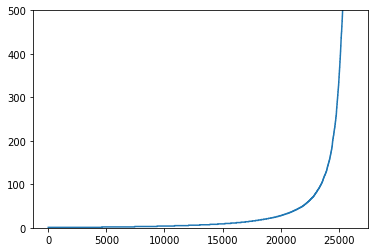

In [68]:
def draw_seg_dist(usr, usr_segment, total_segment, usr_graph=True, total_graph=True):
    if usr_graph:
        x = list(usr_segment[usr].keys())
        y = list(usr_segment[usr].values())
        plt.bar(x,y)

    if total_graph:
        x = list(total_segment.keys())
        y = list(total_segment.values())
#         print(len(x))
#         print(len(y))
#         plt.bar(x[0:100],y[0:100])
        y.sort()

        _, ax = plt.subplots()
#         ax.set_xlim([18500, len(draw_list)])
        ax.set_ylim([0, 500])
        plt.plot(np.arange(1,len(y)+1),y)
        
draw_seg_dist(9899, usr_segment, total_segment,False,True)

NameError: name 'output' is not defined

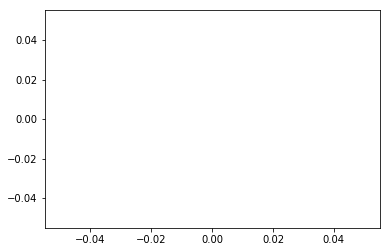

In [32]:
for i in range(len(output[9])):
    if track[i] != 0:
        print(output[9][c])
    c+=86400

dict_items([('uu', 8)])

In [61]:
def count_path_occurrence(raw_string_list, substring_list):
    count = 0
    for i in range(len(raw_string_list)):
        for j in range(len(raw_string_list[i])):
            if raw_string_list[i][j:j + len(substring_list)] == substring_list:
                count += 1
                break
    print(count)
    
a = [['a', '1', 'c'], ['9', 'a', '1', 'a', '1', 'd']]
b = ['a', '1']
count_path_occurrence(a, b)


2
